# 1. Import libraries

In [29]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from datetime import timedelta

try:
    import holidays
except:
    !pip install holidays
    import holidays
try:
    import xgboost as xgb
except:
    !pip install xgboost
    import xgboost as xgb
try:
    from lunardate import LunarDate
except:
    !pip install lunardate
    from lunardate import LunarDate

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.fft import fft
import warnings

warnings.simplefilter(action='ignore')

# 2. Load data

In [2]:
# Define url path to CSV
annex1 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex1.csv'
annex2 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex2.csv'
annex3 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex3.csv'
annex4 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex4.csv'

In [3]:
def get_df_from_url(url):
    # Create request response
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Create a file-like object from the raw content
        csv_content = StringIO(response.text)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_content)

        # Return DataFrame
        return df
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")

df_item = get_df_from_url(annex1)
df_transaction = get_df_from_url(annex2)
df_wholesale = get_df_from_url(annex3)
df_loss = get_df_from_url(annex4)

# 3. Merge and aggregate data

In [4]:
def merge_all_df(df_transaction: pd.DataFrame = df_transaction,
                 df_item: pd.DataFrame = df_item,
                 df_wholesale: pd.DataFrame = df_wholesale,
                 df_loss: pd.DataFrame = df_loss):

    df_merge = df_transaction.merge(df_item,
                                    how = 'left',
                                    on = 'Item Code')
    df_merge = df_merge.merge(df_wholesale,
                            how = 'left',
                            on = ['Date', 'Item Code'])
    df_merge = df_merge.merge(df_loss.drop('Item Name', axis = 1),
                            how = 'left',
                            on = 'Item Code')
    
    return df_merge

df_merge = merge_all_df()

In [5]:
# Create Sales column
df_merge['Sales'] = df_merge['Unit Selling Price (RMB/kg)'] * df_merge['Quantity Sold (kilo)']

# Aggregate as new table
df_agg = df_merge.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()
df_agg.head()

,Date,Category Code,Sales
0,2020-07-01,1011010101,1503.7896
1,2020-07-01,1011010201,592.5300
2,2020-07-01,1011010402,70.2838
3,2020-07-01,1011010501,176.8180
4,2020-07-01,1011010504,759.9902


# 4. Feature Engineering

In [32]:
def create_date_feature(df: pd.DataFrame,
                       date_column: str):
    # Convert the 'Date' column to datetime type
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].astype('datetime64[ns]')

    # Extract date components
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday is 0 and Sunday is 6
    df['WeekNumber'] = df['Date'].dt.isocalendar().week
    df['Quarter'] = df['Date'].dt.quarter

    # df['Year'] = df['Year'].astype('category')
    # df['Month'] = df['Month'].astype('category')
    # df['Day'] = df['Day'].astype('category')
    # df['DayOfWeek'] = df['DayOfWeek'].astype('category')
    # df['WeekNumber'] = df['WeekNumber'].astype('category')
    # df['Quarter'] = df['Quarter'].astype('category')
    
    return df

def is_holiday(date_value):
    china_holidays = holidays.country_holidays('CN')
    value = 1 if date_value in china_holidays else 0
    return value

def create_lag_feature(df: pd.DataFrame,
                       days: int):
    
    df[f'lag_{days}'] = df['Sales'].shift(days)
    
    return df

In [48]:
def get_chinese_new_year_dates(start_year, end_year):
    chinese_new_year_dates = []

    for year in range(start_year, end_year + 1):
        lunar_date = LunarDate(year, 1, 1)
        cny_date = pd.Timestamp(lunar_date.toSolarDate())

        chinese_new_year_dates.append({'Chinese New Year Date': cny_date})

    chinese_new_year_df = pd.DataFrame(chinese_new_year_dates)
    chinese_new_year_df['Last Chinese New Year Date'] = chinese_new_year_df['Chinese New Year Date'].shift(1)
    chinese_new_year_df.dropna(subset=['Last Chinese New Year Date'], inplace = True)
    
    return chinese_new_year_df

def get_chinese_new_year_period(df, days):
    days = 7
    # new_years = df['Chinese New Year Date'].unique()
    # for new_year in new_years:
    new_year_dict = dict(zip(df['Chinese New Year Date'], df['Last Chinese New Year Date']))
    for this_year, last_year in new_year_dict.items():
        for day in range(-days, days + 1):
            if day != 0:
                df = pd.concat([df, pd.DataFrame({'Chinese New Year Date': [this_year + timedelta(days = day)],
                                                  'Last Chinese New Year Date': [last_year + timedelta(days = day)]})],
                               axis = 0,
                               ignore_index = True)
    return df

def create_last_new_year_feature(df: pd.DataFrame,
                                 days_before_after: int):
    
    # Get start and end year to generate Chinese New Year DataFrame from input data
    df['Date'] = df['Date'].astype('datetime64[ns]')
    df['Date'] = pd.to_datetime(df['Date'])
    start_year = df['Date'].min().year
    end_year = df['Date'].max().year
    
    # Get Chinese New Year DataFrame
    df_chinese_new_year = get_chinese_new_year_dates(start_year = start_year,
                                                     end_year = end_year)
    df_chinese_new_year_period = get_chinese_new_year_period(df = df_chinese_new_year,
                                                             days = days_before_after)

    # Cast date column
    df['Date'] = pd.to_datetime(df['Date'])

    # Merge current new year date with last new year date
    df_last_new_year = df.copy()
    df_last_new_year = df_last_new_year.merge(df_chinese_new_year_period,
                                              how = 'left',
                                              left_on = 'Date',
                                              right_on = 'Last Chinese New Year Date')
    # Cleanup DataFrame
    df_last_new_year = df_last_new_year[~df_last_new_year['Last Chinese New Year Date'].isna()][['Chinese New Year Date', 'Category Code', 'Sales']]

    # Change column name before merge avoiding duplicated columns
    df_last_new_year.columns = ['Date', 'Category Code', 'Last New Year Sales']

    # Merge current new year with current new year to get "Last New Year Sales"
    df = df.merge(df_last_new_year,
                #   on = ['Date', 'Category Code', 'Item Code'],
                  on = ['Date', 'Category Code'],
                  how = 'left')

    return df

def apply_fourier_transform(df):
    values = df['Sales'].values
    fourier_transform = fft(values)
    df['fourier_transform'] = np.abs(fourier_transform)
    return df

# 5. Train and evaluate

## 6.1 Train

In [49]:
# categories = df_agg['Category Code'].unique()
# for category in categories:
scaler = StandardScaler()
category = 1011010101
df_category = df_agg[df_agg['Category Code'] == category]

# Feature Engineering
df_category = create_date_feature(df_category,
                                  date_column = 'Date')
df_category = create_lag_feature(df = df_category,
                                 days = 364)
df_category = create_last_new_year_feature(df = df_category,
                                           days_before_after = 7)
df_final = df_category.drop(['Date', 'Category Code'], axis = 1)

,Sales,Year,Month,Day,DayOfWeek,WeekNumber,Quarter,lag_364,Last New Year Sales
0,1503.7896,2020,7,1,2,27,3,NaN,NaN
1,1409.6647,2020,7,2,3,27,3,NaN,NaN
2,1399.5065,2020,7,3,4,27,3,NaN,NaN
3,1841.4000,2020,7,4,5,27,3,NaN,NaN
4,1573.1793,2020,7,5,6,27,3,NaN,NaN


######################################################
################ CATEGORY: 1011010101 ################

[0]	validation_0-rmse:1361.65164	validation_1-rmse:1043.56550
[1000]	validation_0-rmse:543.03682	validation_1-rmse:309.05012
[1179]	validation_0-rmse:464.95597	validation_1-rmse:324.95265
RMSE: 308.81036129390213



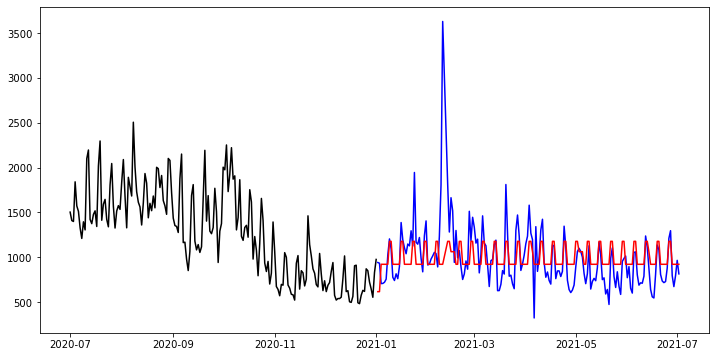

[0]	validation_0-rmse:1215.45795	validation_1-rmse:1149.16769
[1000]	validation_0-rmse:504.12952	validation_1-rmse:699.76672
[2000]	validation_0-rmse:251.05080	validation_1-rmse:510.07493
[3000]	validation_0-rmse:170.43469	validation_1-rmse:439.41735
[4000]	validation_0-rmse:137.13840	validation_1-rmse:420.54850
[5000]	validation_0-rmse:111.71943	validation_1-rmse:412.72856
[6000]	validation_0-rmse:97.42888	validation_1-rmse:408.95361
[7000]	validation_0-rmse:86.61001	validation_1-rmse:406.01093
[8000]	validation_0-rmse:77.10256	validation_1-rmse:404.64428
[9000]	validation_0-rmse:69.69268	validation_1-rmse:403.57583
[9999]	validation_0-rmse:60.92346	validation_1-rmse:401.80108
RMSE: 401.801081800571



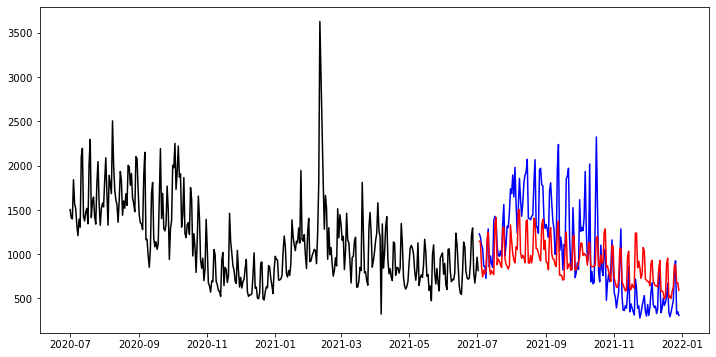

[0]	validation_0-rmse:1193.88935	validation_1-rmse:710.90039
[1000]	validation_0-rmse:494.75296	validation_1-rmse:233.70769
[1314]	validation_0-rmse:387.58115	validation_1-rmse:238.78611
RMSE: 230.4201663692497



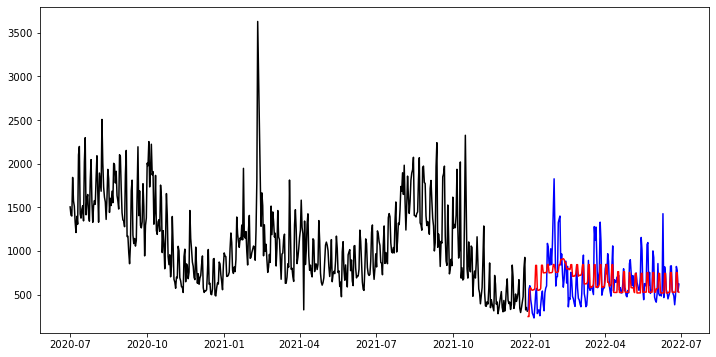

[0]	validation_0-rmse:1094.10550	validation_1-rmse:1165.95315
[1000]	validation_0-rmse:460.69017	validation_1-rmse:669.81430
[2000]	validation_0-rmse:242.15601	validation_1-rmse:537.77582
[3000]	validation_0-rmse:167.52158	validation_1-rmse:501.71559
[4000]	validation_0-rmse:140.34493	validation_1-rmse:489.46929
[5000]	validation_0-rmse:127.67713	validation_1-rmse:484.83171
[5722]	validation_0-rmse:120.96408	validation_1-rmse:484.59629
RMSE: 484.47973493523347



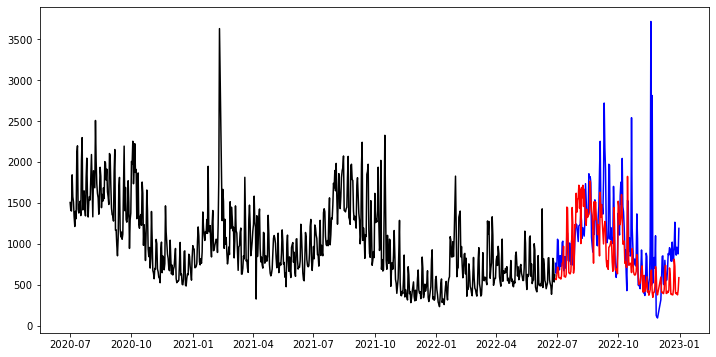

[0]	validation_0-rmse:1108.72923	validation_1-rmse:1036.97070
[1000]	validation_0-rmse:476.98123	validation_1-rmse:644.66640
[2000]	validation_0-rmse:257.83555	validation_1-rmse:518.02082
[3000]	validation_0-rmse:184.31404	validation_1-rmse:476.59234
[4000]	validation_0-rmse:161.37322	validation_1-rmse:457.99820
[5000]	validation_0-rmse:149.40720	validation_1-rmse:450.26648
[6000]	validation_0-rmse:137.94871	validation_1-rmse:447.29745
[6596]	validation_0-rmse:133.19857	validation_1-rmse:447.20703
RMSE: 447.08289739059023



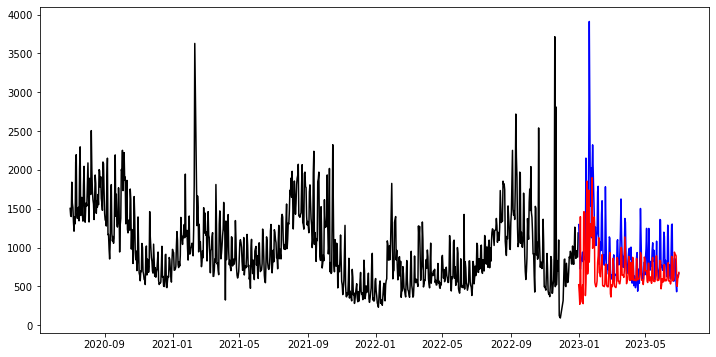

######################################################
################ CATEGORY: 1011010201 ################

[0]	validation_0-rmse:497.69039	validation_1-rmse:387.09554
[1000]	validation_0-rmse:219.00268	validation_1-rmse:183.32845
[1211]	validation_0-rmse:188.22870	validation_1-rmse:186.96430
RMSE: 183.3158081587706



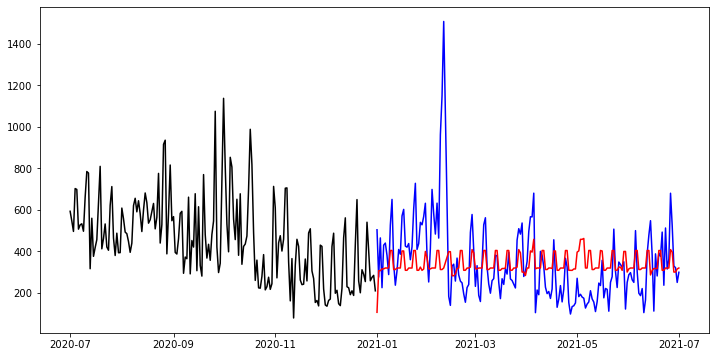

[0]	validation_0-rmse:446.50077	validation_1-rmse:311.43896
[1000]	validation_0-rmse:199.66510	validation_1-rmse:136.70233
[1502]	validation_0-rmse:145.26877	validation_1-rmse:131.31472
RMSE: 130.20930869549255



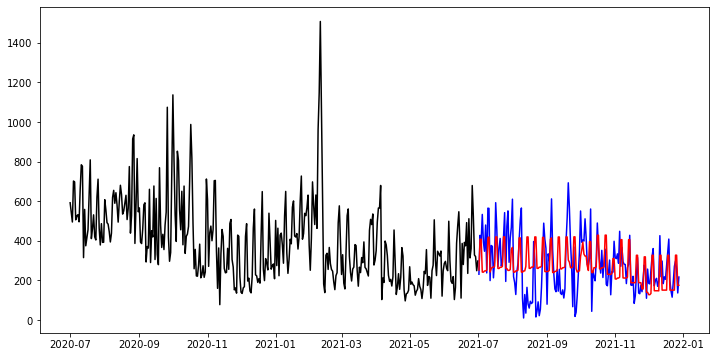

[0]	validation_0-rmse:406.81167	validation_1-rmse:265.87374
[1000]	validation_0-rmse:185.03500	validation_1-rmse:133.53057
[1243]	validation_0-rmse:158.50889	validation_1-rmse:135.90499
RMSE: 133.43558777369336



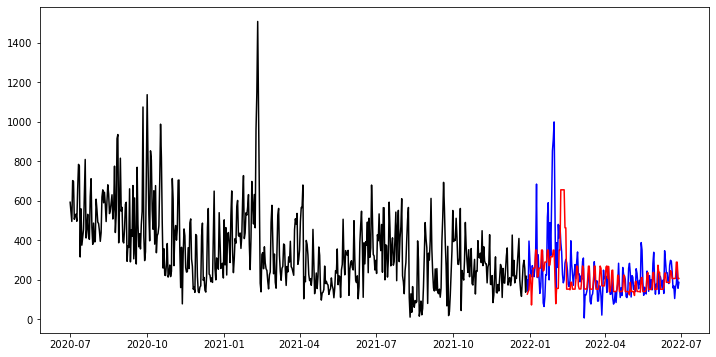

[0]	validation_0-rmse:376.74545	validation_1-rmse:504.72949
[1000]	validation_0-rmse:173.12691	validation_1-rmse:391.69620
[2000]	validation_0-rmse:104.27432	validation_1-rmse:346.20235
[3000]	validation_0-rmse:81.88369	validation_1-rmse:329.86630
[4000]	validation_0-rmse:71.61900	validation_1-rmse:321.16295
[5000]	validation_0-rmse:65.03158	validation_1-rmse:317.71024
[6000]	validation_0-rmse:60.79877	validation_1-rmse:316.06001
[7000]	validation_0-rmse:58.04007	validation_1-rmse:314.67405
[7655]	validation_0-rmse:56.29394	validation_1-rmse:314.52086
RMSE: 314.50939767393623



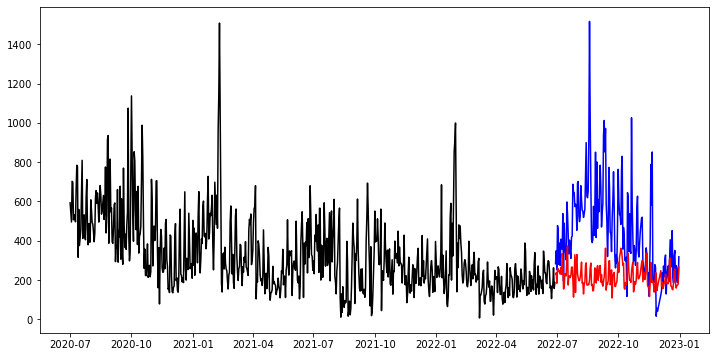

[0]	validation_0-rmse:405.39719	validation_1-rmse:368.80981
[1000]	validation_0-rmse:188.35597	validation_1-rmse:242.47188
[2000]	validation_0-rmse:117.20477	validation_1-rmse:203.27463
[3000]	validation_0-rmse:95.24175	validation_1-rmse:193.52734
[4000]	validation_0-rmse:83.18143	validation_1-rmse:189.29049
[5000]	validation_0-rmse:76.75809	validation_1-rmse:187.28178
[5195]	validation_0-rmse:75.50411	validation_1-rmse:187.30761
RMSE: 187.27658377263347



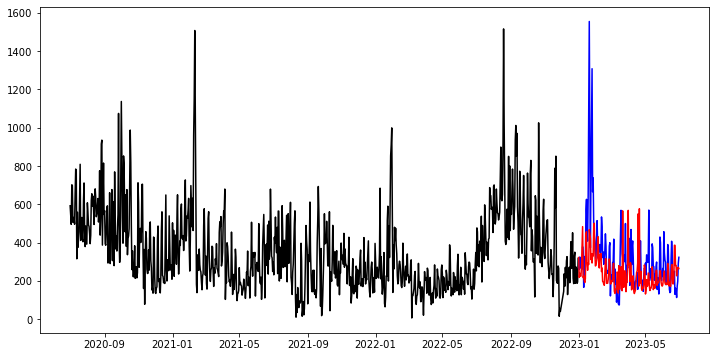

######################################################
################ CATEGORY: 1011010402 ################

[0]	validation_0-rmse:335.24523	validation_1-rmse:551.08266
[1000]	validation_0-rmse:155.42846	validation_1-rmse:507.26615
[2000]	validation_0-rmse:87.19868	validation_1-rmse:488.45594
[3000]	validation_0-rmse:60.39755	validation_1-rmse:480.93322
[4000]	validation_0-rmse:46.94139	validation_1-rmse:479.22051
[4789]	validation_0-rmse:40.53531	validation_1-rmse:478.68257
RMSE: 478.6804936851842



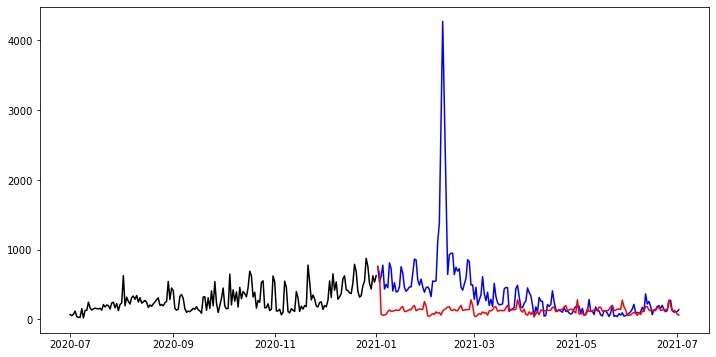

[0]	validation_0-rmse:454.46097	validation_1-rmse:311.28177
[1000]	validation_0-rmse:223.80016	validation_1-rmse:167.29515
[2000]	validation_0-rmse:130.12047	validation_1-rmse:145.23031
[2334]	validation_0-rmse:111.39155	validation_1-rmse:145.27996
RMSE: 145.038038452143



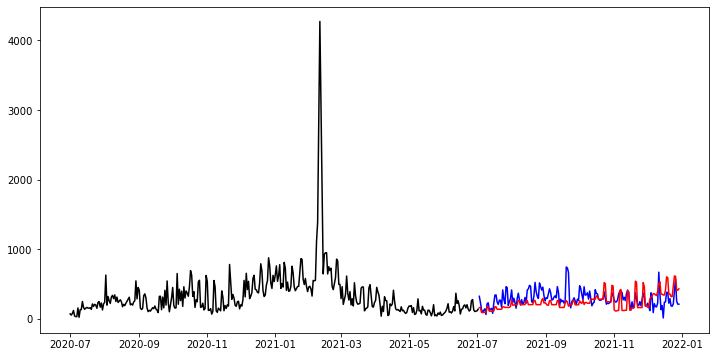

[0]	validation_0-rmse:412.69995	validation_1-rmse:413.24096
[785]	validation_0-rmse:231.30532	validation_1-rmse:347.88374
RMSE: 342.6811589254009



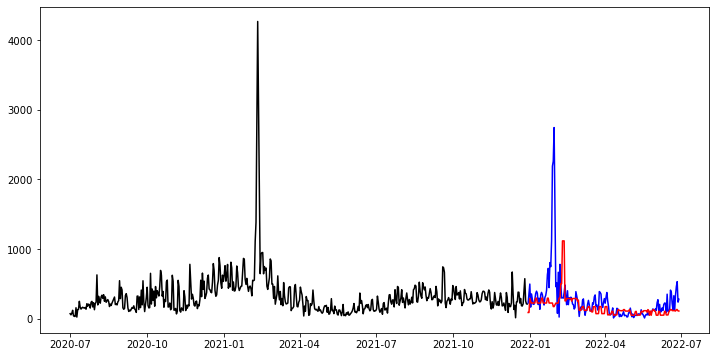

[0]	validation_0-rmse:412.82799	validation_1-rmse:546.99544
[1000]	validation_0-rmse:200.74849	validation_1-rmse:396.01932
[2000]	validation_0-rmse:121.77585	validation_1-rmse:342.88618
[3000]	validation_0-rmse:89.90280	validation_1-rmse:324.39713
[4000]	validation_0-rmse:75.18321	validation_1-rmse:316.39088
[5000]	validation_0-rmse:67.48293	validation_1-rmse:312.55381
[5982]	validation_0-rmse:60.48226	validation_1-rmse:311.64167
RMSE: 311.51582163565934



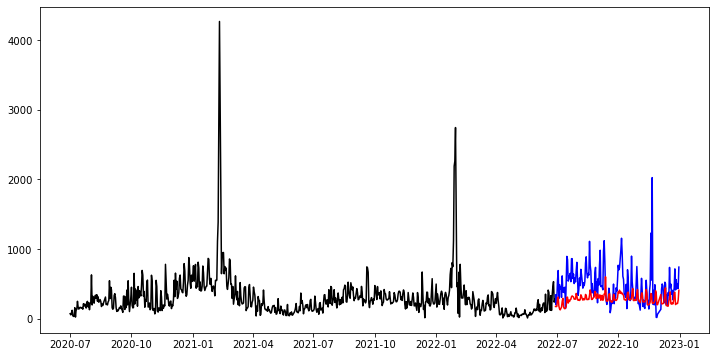

[0]	validation_0-rmse:442.71892	validation_1-rmse:349.14957
[1000]	validation_0-rmse:223.62477	validation_1-rmse:201.52474
[2000]	validation_0-rmse:148.35789	validation_1-rmse:166.05679
[3000]	validation_0-rmse:121.43362	validation_1-rmse:157.22463
[4000]	validation_0-rmse:106.59693	validation_1-rmse:153.80068
[4298]	validation_0-rmse:102.80576	validation_1-rmse:153.85239
RMSE: 153.73426972113896



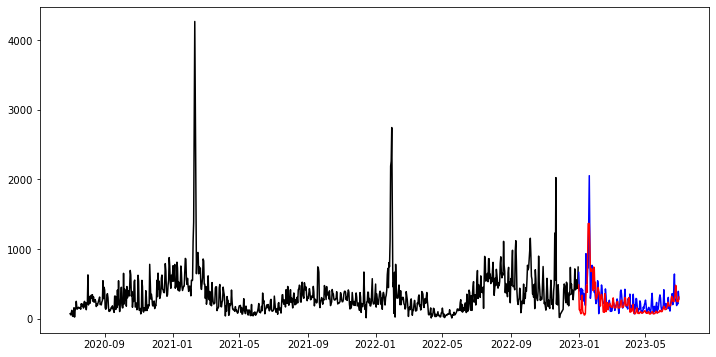

######################################################
################ CATEGORY: 1011010501 ################

[0]	validation_0-rmse:217.67389	validation_1-rmse:241.65496
[1000]	validation_0-rmse:92.54328	validation_1-rmse:153.82350
[1418]	validation_0-rmse:67.43140	validation_1-rmse:152.41751
RMSE: 151.62161100861584



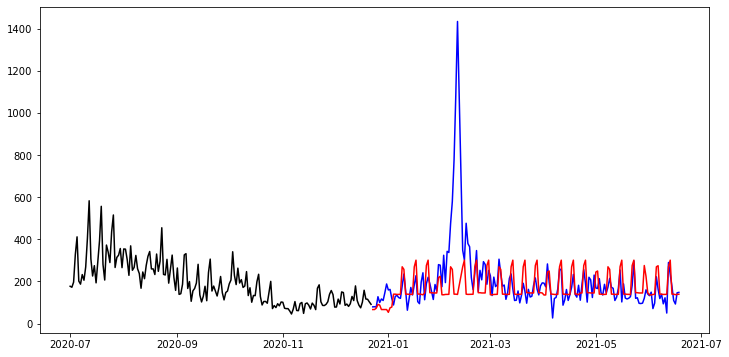

[0]	validation_0-rmse:229.98853	validation_1-rmse:180.44877
[1000]	validation_0-rmse:104.35634	validation_1-rmse:97.61140
[2000]	validation_0-rmse:55.88837	validation_1-rmse:67.90468
[3000]	validation_0-rmse:36.63699	validation_1-rmse:59.13082
[4000]	validation_0-rmse:28.03269	validation_1-rmse:57.56665
[5000]	validation_0-rmse:23.72509	validation_1-rmse:57.13870
[5398]	validation_0-rmse:22.38308	validation_1-rmse:57.11291
RMSE: 57.0695486898484



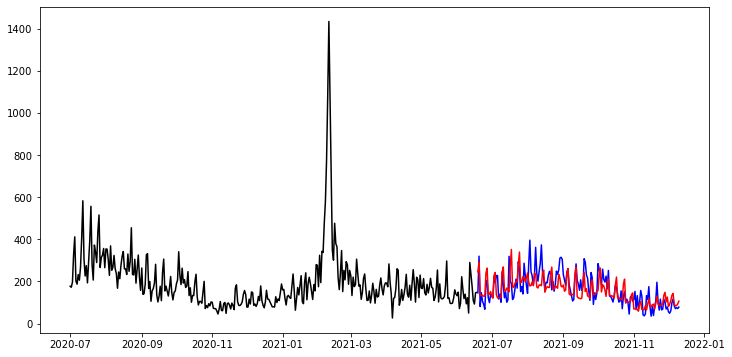

[0]	validation_0-rmse:214.73627	validation_1-rmse:297.32616
[1000]	validation_0-rmse:96.72730	validation_1-rmse:219.00472
[1852]	validation_0-rmse:57.44925	validation_1-rmse:209.99476
RMSE: 209.89169080385042



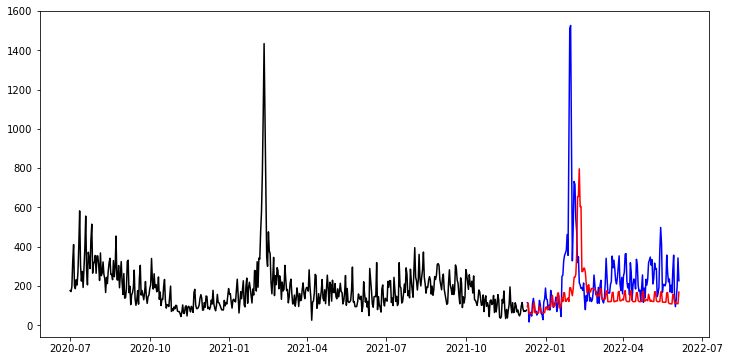

[0]	validation_0-rmse:238.06298	validation_1-rmse:149.95401
[1000]	validation_0-rmse:118.41714	validation_1-rmse:82.24293
[1484]	validation_0-rmse:94.81132	validation_1-rmse:81.28275
RMSE: 80.62496944694755



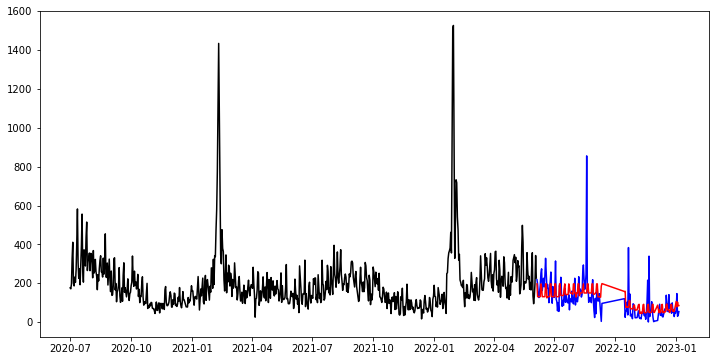

[0]	validation_0-rmse:223.24655	validation_1-rmse:229.29897
[1000]	validation_0-rmse:113.95296	validation_1-rmse:111.38167
[2000]	validation_0-rmse:79.62358	validation_1-rmse:94.89023
[2002]	validation_0-rmse:79.57106	validation_1-rmse:94.92381
RMSE: 93.61091211632917



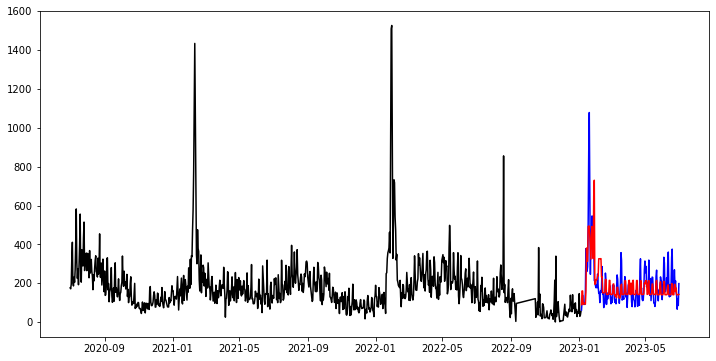

######################################################
################ CATEGORY: 1011010504 ################

[0]	validation_0-rmse:709.19681	validation_1-rmse:1514.47758
[1000]	validation_0-rmse:288.73996	validation_1-rmse:1286.16560
[2000]	validation_0-rmse:136.20209	validation_1-rmse:1235.92261
[3000]	validation_0-rmse:80.46077	validation_1-rmse:1213.78692
[3291]	validation_0-rmse:72.16263	validation_1-rmse:1214.07469
RMSE: 1213.6928912254884



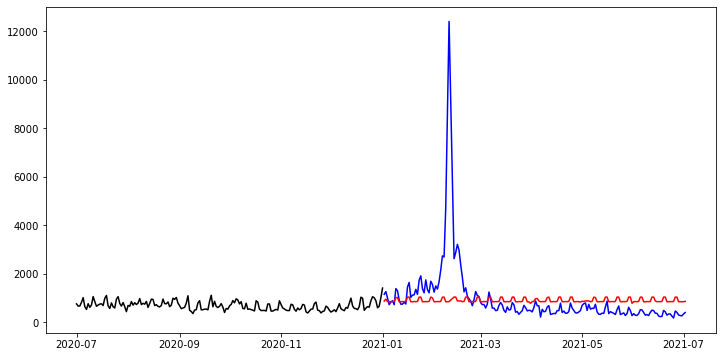

[0]	validation_0-rmse:1176.87082	validation_1-rmse:416.52375
[1000]	validation_0-rmse:570.13349	validation_1-rmse:115.78672
[1580]	validation_0-rmse:394.30886	validation_1-rmse:111.43768
RMSE: 108.61836204738137



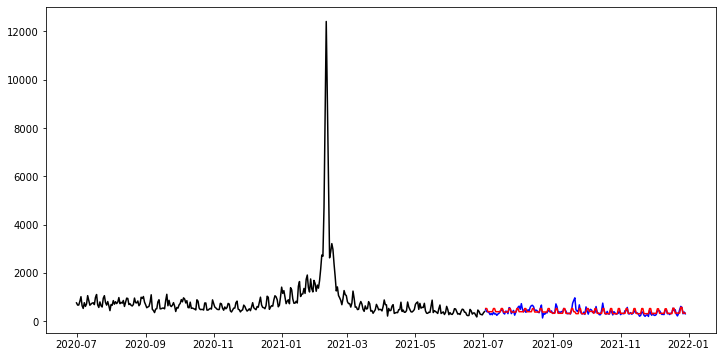

[0]	validation_0-rmse:992.45267	validation_1-rmse:1103.00817
[728]	validation_0-rmse:576.83911	validation_1-rmse:948.42276
RMSE: 935.9492689247189



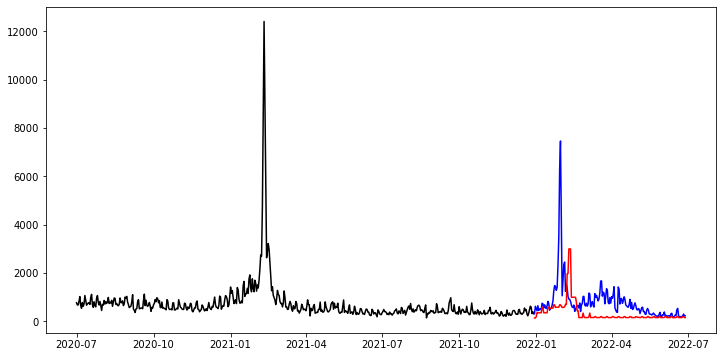

[0]	validation_0-rmse:1020.98726	validation_1-rmse:686.91375
[1000]	validation_0-rmse:498.16768	validation_1-rmse:529.66781
[2000]	validation_0-rmse:273.71188	validation_1-rmse:457.66968
[3000]	validation_0-rmse:169.17485	validation_1-rmse:428.31959
[4000]	validation_0-rmse:120.03017	validation_1-rmse:417.66723
[5000]	validation_0-rmse:95.14262	validation_1-rmse:413.57998
[6000]	validation_0-rmse:82.85493	validation_1-rmse:411.82316
[6744]	validation_0-rmse:77.43671	validation_1-rmse:411.54856
RMSE: 411.51070777172777



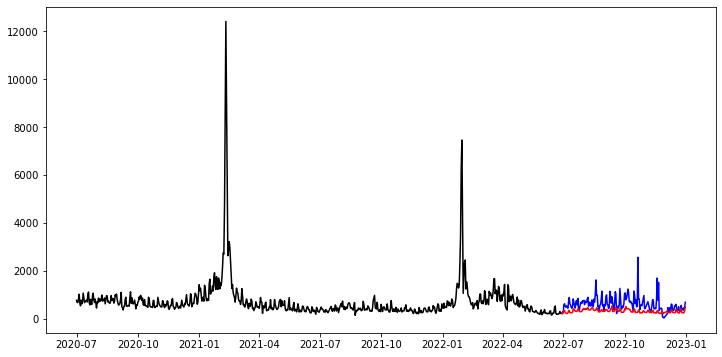

[0]	validation_0-rmse:963.77635	validation_1-rmse:991.59601
[1000]	validation_0-rmse:473.46007	validation_1-rmse:596.21702
[1427]	validation_0-rmse:363.97350	validation_1-rmse:584.18658
RMSE: 580.3603644941286



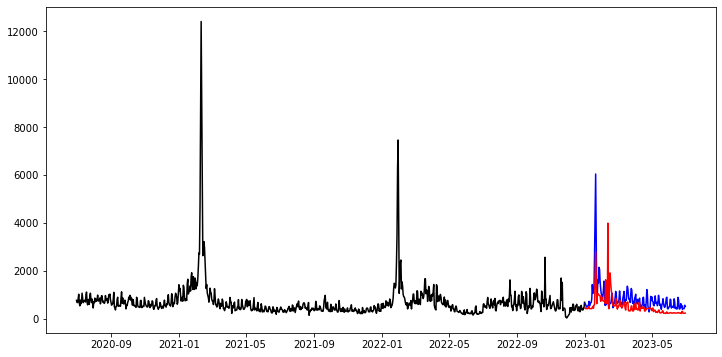

######################################################
################ CATEGORY: 1011010801 ################

[0]	validation_0-rmse:803.66543	validation_1-rmse:843.55047
[1000]	validation_0-rmse:338.36881	validation_1-rmse:590.24087
[2000]	validation_0-rmse:167.55606	validation_1-rmse:551.60321
[3000]	validation_0-rmse:99.97284	validation_1-rmse:544.91964
[4000]	validation_0-rmse:69.91569	validation_1-rmse:543.74455
[4002]	validation_0-rmse:69.86864	validation_1-rmse:543.74827
RMSE: 543.6921601130448



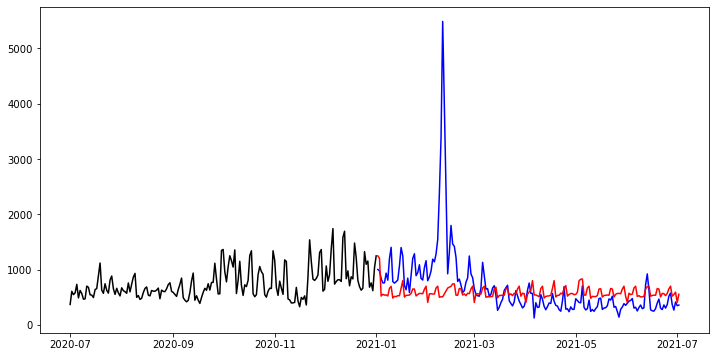

[0]	validation_0-rmse:823.49372	validation_1-rmse:547.95267
[1000]	validation_0-rmse:371.03999	validation_1-rmse:272.68451
[1406]	validation_0-rmse:280.80086	validation_1-rmse:270.03021
RMSE: 266.92626010366774



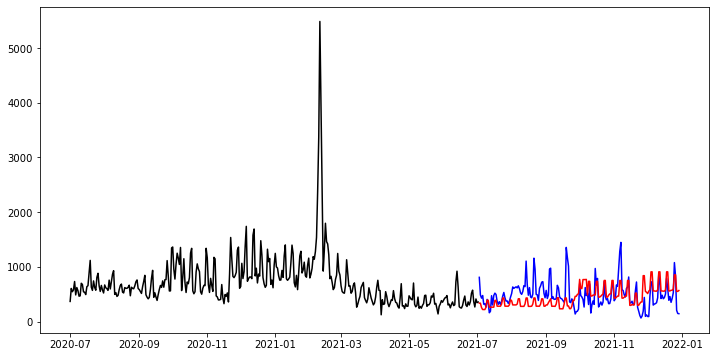

[0]	validation_0-rmse:743.88567	validation_1-rmse:420.55029
[773]	validation_0-rmse:399.10636	validation_1-rmse:274.11812
RMSE: 263.6937498627012



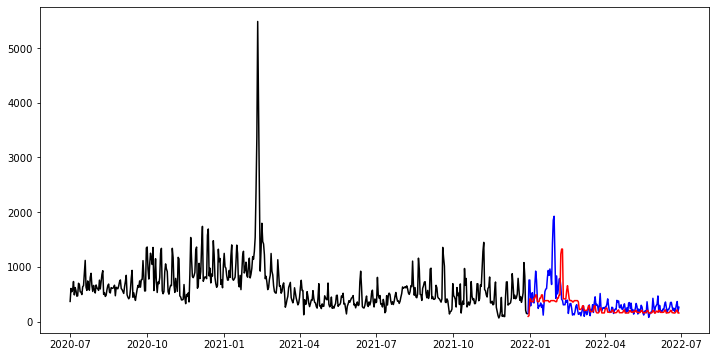

[0]	validation_0-rmse:678.18526	validation_1-rmse:695.30171
[1000]	validation_0-rmse:309.18531	validation_1-rmse:450.81896
[2000]	validation_0-rmse:171.51066	validation_1-rmse:383.97057
[3000]	validation_0-rmse:118.57486	validation_1-rmse:354.80601
[4000]	validation_0-rmse:93.76420	validation_1-rmse:348.56593
[5000]	validation_0-rmse:80.45575	validation_1-rmse:346.31004
[6000]	validation_0-rmse:72.15170	validation_1-rmse:345.52058
[6202]	validation_0-rmse:70.91716	validation_1-rmse:346.20552
RMSE: 345.510719339647



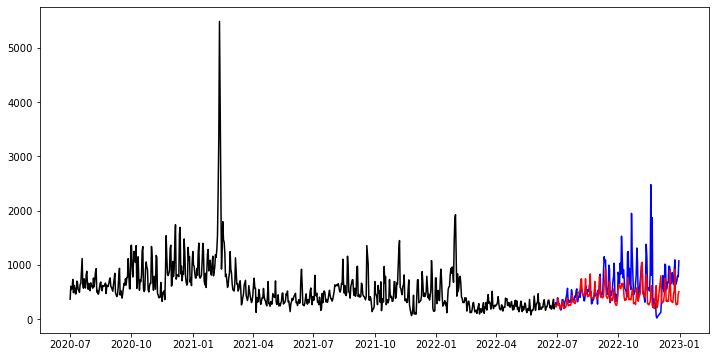

[0]	validation_0-rmse:681.59479	validation_1-rmse:732.37119
[1000]	validation_0-rmse:316.60682	validation_1-rmse:555.44786
[2000]	validation_0-rmse:188.04401	validation_1-rmse:497.45611
[3000]	validation_0-rmse:138.03682	validation_1-rmse:473.87405
[4000]	validation_0-rmse:114.62631	validation_1-rmse:463.30723
[5000]	validation_0-rmse:101.14176	validation_1-rmse:459.19789
[6000]	validation_0-rmse:92.61976	validation_1-rmse:456.96974
[7000]	validation_0-rmse:87.30188	validation_1-rmse:456.15246
[7158]	validation_0-rmse:86.39753	validation_1-rmse:456.17743
RMSE: 456.1460367877814



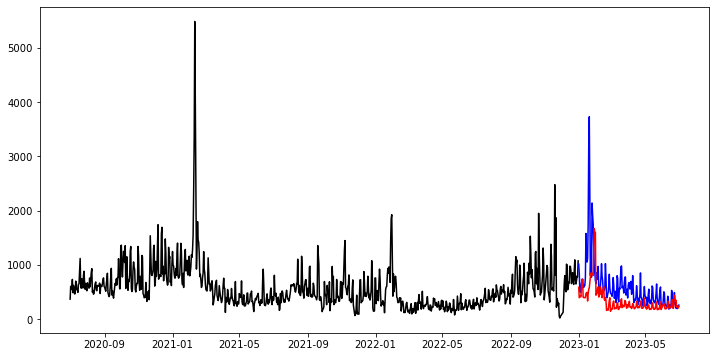

############ AVERAGE RMSE: 332.39699876731595 ############


,Year,Month,Day,DayOfWeek,WeekNumber,Quarter,lag_364,Last New Year Sales,is_holiday
0,-1.590494,-0.033398,-1.687747,-0.500552,-0.150167,0.268832,NaN,NaN,-0.244375
1,-1.590494,-0.033398,-1.573667,-0.001104,-0.150167,0.268832,NaN,NaN,-0.244375
2,-1.590494,-0.033398,-1.459587,0.498345,-0.150167,0.268832,NaN,NaN,-0.244375
3,-1.590494,-0.033398,-1.345508,0.997794,-0.150167,0.268832,NaN,NaN,-0.244375
4,-1.590494,-0.033398,-1.231428,1.497242,-0.150167,0.268832,NaN,NaN,-0.244375
...,...,...,...,...,...,...,...,...,...
900,1.077527,1.448228,1.278321,-1.000001,1.536790,1.183466,-0.446344,NaN,-0.244375
901,1.077527,1.448228,1.392400,-0.500552,1.536790,1.183466,-0.713377,NaN,-0.244375
902,1.077527,1.448228,1.506480,-0.001104,1.536790,1.183466,-0.529391,NaN,-0.244375
903,1.077527,1.448228,1.620559,0.498345,1.536790,1.183466,-0.269021,NaN,-0.244375


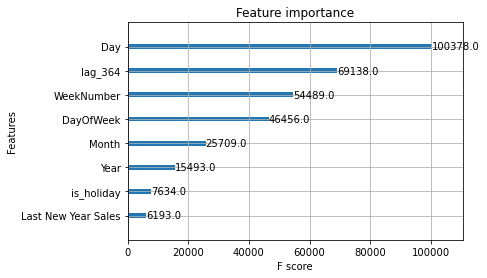

In [55]:
scaler = StandardScaler()
all_rmse = []
xgb_r = xgb.XGBRegressor(
    n_estimators = 10000,
    eval_metrics = mean_squared_error,
    early_stopping_rounds = 200,
    learning_rate = 0.001,
    max_depth = 6,
    random_state = 244
)

categories = df_agg['Category Code'].unique()
for category in categories:
    df_category = df_agg[df_agg['Category Code'] == category]
    print('######################################################')
    print(f'################ CATEGORY: {category} ################\n')

    # Feature Engineering
    df_category = create_date_feature(df_category,
                                    date_column = 'Date')
    df_category = create_lag_feature(df = df_category,
                                    days = 364)
    df_category = create_last_new_year_feature(df = df_category,
                                            days_before_after = 7)
    df_category['is_holiday'] = df_category['Date'].apply(is_holiday)
    df_final = df_category.drop(['Date', 'Category Code'], axis = 1)

    # Start Training Loop
    X = df_final.drop('Sales', axis = 1)
    y = df_final[['Sales']]
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits = n_splits)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Scale X
        X_train[X_train.columns] = scaler.fit_transform(X_train)
        X_test[X_test.columns] = scaler.transform(X_test)
        
        # Fit the model
        xgb_r.fit(X = X_train,
                y = y_train,
                eval_set = [(X_train, y_train), (X_test, y_test)],
                verbose = 1000)
        
        # Predict
        y_pred = xgb_r.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        all_rmse.append(rmse)
        print(f'\nRMSE: {rmse}\n')
        
        # Plot True vs. Predicted Labelse
        plt.figure(figsize=(12, 6))
        plt.plot(df_category.iloc[train_index]['Date'], y_train, c = 'black')
        plt.plot(df_category.iloc[test_index]['Date'], y_test, c = 'b')
        plt.plot(df_category.iloc[test_index]['Date'], y_pred, c = 'r')
        plt.show()

print(f'############ AVERAGE RMSE: {sum(all_rmse) / len(all_rmse)} ############')
xgb.plot_importance(xgb_r)
display(X_train)

In [12]:
df_category.iloc[train_index]

,Sales,Year,Month,Day,DayOfWeek,WeekNumber,Quarter
0,1503.7896,2020,7,1,2,27,3
6,1409.6647,2020,7,2,3,27,3
12,1399.5065,2020,7,3,4,27,3
18,1841.4000,2020,7,4,5,27,3
24,1573.1793,2020,7,5,6,27,3
...,...,...,...,...,...,...,...
1080,724.4486,2020,12,28,0,53,4
1086,647.9890,2020,12,29,1,53,4
1092,554.7568,2020,12,30,2,53,4
1098,830.7594,2020,12,31,3,53,4


In [35]:
X.dtypes

Year           int64
Month          int64
Day            int64
DayOfWeek      int64
WeekNumber    UInt32
Quarter        int64
dtype: object

In [34]:
def category_train_loop(df: pd.DataFrame, 
                        categories: list, 
                        xgb_model,
                        scaler = None,
                        include_item: bool = False):
    """
    Loop all category and train in each model separatelly
    """

    test_all = pd.DataFrame()
    y_pred_all = []
    for category in categories:
        print(f'Catgory Trainig: {category}')

        # Slice DataFrame to each category
        df_category = df[df['Category Code'] == category]

        # Aggregate
        df_category = df_category.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()
        
        # Create lag feature
        df_category = create_days_lag_feature(df = df_category,
                                                days = 365,
                                                grouping_column = ['Date', 'Category Code'])
        df_category = create_days_lag_feature(df = df_category,
                                                days = 364,
                                                grouping_column = ['Date', 'Category Code'])
            
        df_category = df_category[df_category['Category Code'] == category]
        
        # Create Last New Year Sales
        df_category = create_last_new_year_feature(df = df_category,
                                                   days_before_after = 7)
        
        # Feature holiday
        df_category['is_holiday'] = df_category['Date'].apply(is_holiday)

        # Create date feature
        df_category = create_date_feature(df = df_category,
                                          date_column = 'Date')
                                          
        ##################### OLD VERSION #####################
        # # Split train and test
        # train_split = create_split_date(df = df_category,
        #                                 date_column = 'Date',
        #                                 train_size = 0.8)
        # train, test = split_train_test_date(df = df_category,
        #                                     split_date = train_split)

        # # Create X and y to train and test
        # X_train, y_train = train.drop('Sales', axis = 1), train[['Sales']]
        # X_test, y_test = test.drop('Sales', axis = 1), test[['Sales']]
        #######################################################
        display(df_category)
        df_category = df_category.drop('Date', axis = 1)
        df_category = df_category.reset_index()
        X = df_category.drop('Sales', axis = 1)
        y = df_category[['Sales']]

        tscv = TimeSeriesSplit(n_splits = 5)

        # Iterate over the splits
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            test = df_category.iloc[test_index]

            # Scale data
            if scaler:
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
            else:
                pass

            ### Training
            print(f'Training...')
            xgb_model.fit(X = X_train, y = y_train)
                        # eval_set = [(X_train, y_train), (X_test, y_test)],
                        # verbose = 200)
            print('--------------------------------------------\n')

            ### Predict
            y_pred = xgb_model.predict(X_test)

            # Append data to all data
            test_all = pd.concat([test_all, test], axis = 0)
            y_pred_all = np.concatenate((y_pred_all, y_pred))

    return test_all, y_pred_all

def plot_prediction(df_test: pd.DataFrame,
                    y_pred):
    
    # Merge prediction to test data
    df_predict = df_test.reset_index().merge(pd.DataFrame(data = y_pred, columns = ['prediction']),
                                             how = 'left',
                                             left_index = True,
                                             right_index = True)
    df_predict['Date'] = pd.to_datetime(df_predict[['Year', 'Month', 'Day']])

    # Aggregate to Category level
    df_predict_agg = df_predict.groupby(['Date','Category Code'], as_index = False)[['Sales','prediction']].sum()

    # Calculate RMSE in Category level
    rmse = np.sqrt(mean_squared_error(y_true = df_predict_agg['Sales'],
                                        y_pred = df_predict_agg['prediction']))
    range = max(df_predict_agg['Sales']) - min(df_predict_agg['Sales'])
    normalized_rmse = rmse / range
    print(f'RMSE: {rmse:.2f}')
    print(f'Normalized RMSE: {normalized_rmse:.2f}')

    # Plot prediction
    plt.figure(figsize = (10,5))
    sns.lineplot(data = df_predict.groupby('Date')['Sales'].sum(), label = 'True label')
    sns.lineplot(data = df_predict.groupby('Date')['prediction'].sum(), label = 'Prediction')
    plt.show()
    

In [36]:
warnings.filterwarnings("ignore", category=RuntimeWarning) 
categories = df_agg['Category Code'].unique()
scaler = StandardScaler()
xgb_reg = xgb.XGBRegressor(n_estimators = 5000,
                            eval_metrics = mean_squared_error,
                            enable_categorical = True,
                            # early_stopping_rounds = 200,
                            learning_rate = 0.001,
                            max_depth = 5,
                            random_state = 244)

df_test, y_pred = category_train_loop(categories = categories,
                                      df = df_agg,
                                      xgb_model = xgb_reg,
                                      scaler = scaler,
                                      include_item = False)

Catgory Trainig: 1011010101


,Date,Category Code,Sales,Sales_365_daylag,Sales_364_daylag,Last New Year Sales,is_holiday,Year,Month,Day,DayOfWeek,WeekNumber,Quarter
0,2020-07-01,1011010101,1503.828125,NaN,NaN,NaN,0,2020,7,1,2,27,3
1,2020-07-02,1011010101,1409.601562,NaN,NaN,NaN,0,2020,7,2,3,27,3
2,2020-07-03,1011010101,1399.484375,NaN,NaN,NaN,0,2020,7,3,4,27,3
3,2020-07-04,1011010101,1841.281250,NaN,NaN,NaN,0,2020,7,4,5,27,3
4,2020-07-05,1011010101,1573.187500,NaN,NaN,NaN,0,2020,7,5,6,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,2023-06-26,1011010101,430.554688,777.398438,532.441406,NaN,0,2023,6,26,0,26,2
1081,2023-06-27,1011010101,642.158203,532.441406,619.060547,NaN,0,2023,6,27,1,26,2
1082,2023-06-28,1011010101,630.476562,619.060547,760.561523,NaN,0,2023,6,28,2,26,2
1083,2023-06-29,1011010101,646.160156,760.561523,637.993164,NaN,0,2023,6,29,3,26,2


Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Catgory Trainig: 1011010201


,Date,Category Code,Sales,Sales_365_daylag,Sales_364_daylag,Last New Year Sales,is_holiday,Year,Month,Day,DayOfWeek,WeekNumber,Quarter
0,2020-07-01,1011010201,592.50000,NaN,NaN,NaN,0,2020,7,1,2,27,3
1,2020-07-02,1011010201,546.00000,NaN,NaN,NaN,0,2020,7,2,3,27,3
2,2020-07-03,1011010201,495.43750,NaN,NaN,NaN,0,2020,7,3,4,27,3
3,2020-07-04,1011010201,702.25000,NaN,NaN,NaN,0,2020,7,4,5,27,3
4,2020-07-05,1011010201,697.87500,NaN,NaN,NaN,0,2020,7,5,6,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,2023-06-26,1011010201,113.18750,261.5000,156.7500,NaN,0,2023,6,26,0,26,2
1081,2023-06-27,1011010201,171.25000,156.7500,186.5000,NaN,0,2023,6,27,1,26,2
1082,2023-06-28,1011010201,198.09375,186.5000,282.9375,NaN,0,2023,6,28,2,26,2
1083,2023-06-29,1011010201,292.50000,282.9375,348.3750,NaN,0,2023,6,29,3,26,2


Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Catgory Trainig: 1011010402


,Date,Category Code,Sales,Sales_365_daylag,Sales_364_daylag,Last New Year Sales,is_holiday,Year,Month,Day,DayOfWeek,WeekNumber,Quarter
0,2020-07-01,1011010402,70.281250,NaN,NaN,NaN,0,2020,7,1,2,27,3
1,2020-07-02,1011010402,53.109375,NaN,NaN,NaN,0,2020,7,2,3,27,3
2,2020-07-03,1011010402,76.687500,NaN,NaN,NaN,0,2020,7,3,4,27,3
3,2020-07-04,1011010402,118.750000,NaN,NaN,NaN,0,2020,7,4,5,27,3
4,2020-07-05,1011010402,40.187500,NaN,NaN,NaN,0,2020,7,5,6,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,2023-06-26,1011010402,186.539062,530.687500,235.867188,NaN,0,2023,6,26,0,26,2
1081,2023-06-27,1011010402,263.025391,235.867188,278.059570,NaN,0,2023,6,27,1,26,2
1082,2023-06-28,1011010402,209.429688,278.059570,341.039062,NaN,0,2023,6,28,2,26,2
1083,2023-06-29,1011010402,391.542969,341.039062,194.869141,NaN,0,2023,6,29,3,26,2


Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Catgory Trainig: 1011010501


,Date,Category Code,Sales,Sales_365_daylag,Sales_364_daylag,Last New Year Sales,is_holiday,Year,Month,Day,DayOfWeek,WeekNumber,Quarter
0,2020-07-01,1011010501,176.812500,NaN,NaN,NaN,0,2020,7,1,2,27,3
1,2020-07-02,1011010501,172.062500,NaN,NaN,NaN,0,2020,7,2,3,27,3
2,2020-07-03,1011010501,196.250000,NaN,NaN,NaN,0,2020,7,3,4,27,3
3,2020-07-04,1011010501,327.437500,NaN,NaN,NaN,0,2020,7,4,5,27,3
4,2020-07-05,1011010501,411.312500,NaN,NaN,NaN,0,2020,7,5,6,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,2023-06-26,1011010501,134.968750,258.257812,166.207031,NaN,0,2023,6,26,0,26,2
1081,2023-06-27,1011010501,67.121094,166.207031,98.023438,NaN,0,2023,6,27,1,26,2
1082,2023-06-28,1011010501,121.625000,98.023438,183.394531,NaN,0,2023,6,28,2,26,2
1083,2023-06-29,1011010501,86.351562,183.394531,139.929688,NaN,0,2023,6,29,3,26,2


Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Catgory Trainig: 1011010504


,Date,Category Code,Sales,Sales_365_daylag,Sales_364_daylag,Last New Year Sales,is_holiday,Year,Month,Day,DayOfWeek,WeekNumber,Quarter
0,2020-07-01,1011010504,759.890625,NaN,NaN,NaN,0,2020,7,1,2,27,3
1,2020-07-02,1011010504,669.648438,NaN,NaN,NaN,0,2020,7,2,3,27,3
2,2020-07-03,1011010504,670.640625,NaN,NaN,NaN,0,2020,7,3,4,27,3
3,2020-07-04,1011010504,826.515625,NaN,NaN,NaN,0,2020,7,4,5,27,3
4,2020-07-05,1011010504,1016.308594,NaN,NaN,NaN,0,2020,7,5,6,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,2023-06-26,1011010504,425.519531,292.468750,218.175781,NaN,0,2023,6,26,0,26,2
1081,2023-06-27,1011010504,422.820312,218.175781,218.136719,NaN,0,2023,6,27,1,26,2
1082,2023-06-28,1011010504,415.398438,218.136719,224.415527,NaN,0,2023,6,28,2,26,2
1083,2023-06-29,1011010504,556.373047,224.415527,270.890625,NaN,0,2023,6,29,3,26,2


Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Catgory Trainig: 1011010801


,Date,Category Code,Sales,Sales_365_daylag,Sales_364_daylag,Last New Year Sales,is_holiday,Year,Month,Day,DayOfWeek,WeekNumber,Quarter
0,2020-07-01,1011010801,368.648438,NaN,NaN,NaN,0,2020,7,1,2,27,3
1,2020-07-02,1011010801,605.984375,NaN,NaN,NaN,0,2020,7,2,3,27,3
2,2020-07-03,1011010801,546.312500,NaN,NaN,NaN,0,2020,7,3,4,27,3
3,2020-07-04,1011010801,578.578125,NaN,NaN,NaN,0,2020,7,4,5,27,3
4,2020-07-05,1011010801,732.687500,NaN,NaN,NaN,0,2020,7,5,6,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,2023-06-26,1011010801,216.644531,366.304688,187.835938,NaN,0,2023,6,26,0,26,2
1081,2023-06-27,1011010801,193.882812,187.835938,262.460938,NaN,0,2023,6,27,1,26,2
1082,2023-06-28,1011010801,247.941406,262.460938,300.976562,NaN,0,2023,6,28,2,26,2
1083,2023-06-29,1011010801,225.980469,300.976562,250.632812,NaN,0,2023,6,29,3,26,2


Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------

Training...
--------------------------------------------



# 7. Results

RMSE: 393.83
Normalized RMSE: 0.03


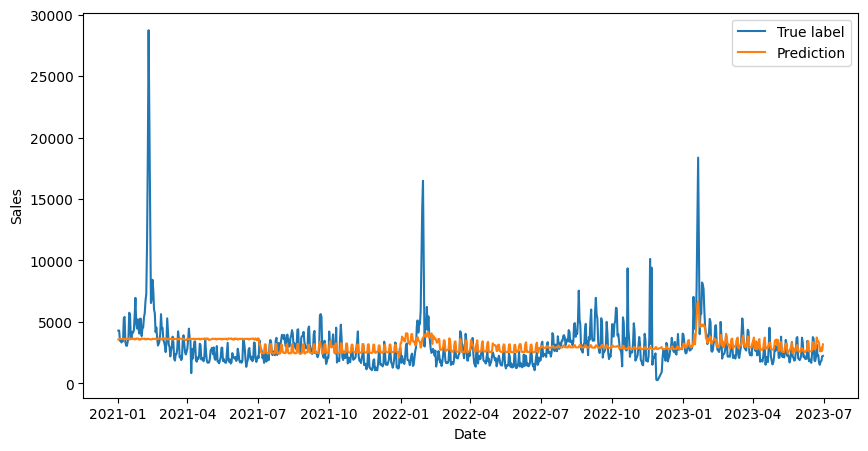

In [33]:
plot_prediction(df_test = df_test,
                y_pred = y_pred)

In [22]:
df_predict = df_test.reset_index().merge(pd.DataFrame(data = y_pred, columns = ['prediction']),
                                             how = 'left',
                                             left_index = True,
                                             right_index = True)
df_predict['Abs Error'] = abs(df_predict['Sales'] - df_predict['prediction'])
df_predict.sort_values(by = 'Abs Error', ascending = False).head()

,index,Category Code,Sales,Sales_365_daylag,Sales_364_daylag,is_holiday,Year,Month,Day,DayOfWeek,WeekNumber,Quarter,prediction,Abs Error
5458,5548,1011010504,6036.382812,657.947266,831.328125,0,2023,1,20,4,3,1,732.385620,5303.997192
5452,5542,1011010504,4398.406250,540.995117,657.947266,0,2023,1,19,3,3,1,732.385620,3666.020630
318,5544,1011010101,3911.250000,573.203125,597.609375,0,2023,1,20,4,3,1,625.118164,3286.131836
6743,5549,1011010801,3731.937500,593.210938,602.474609,0,2023,1,20,4,3,1,600.417603,3131.519897
6737,5543,1011010801,3173.509766,546.207031,593.210938,0,2023,1,19,3,3,1,397.046234,2776.463531


In [ ]:
# sns.lineplot(data = df_test[df_test ])
df_test